In [ ]:
!pip install requests pandas numpy


In [7]:
import requests
import json
import pandas as pd

def fetch_windborne_data():
    base_url = "https://a.windbornesystems.com/treasure/"
    all_data = {hour: None for hour in range(24)}  

    for hour in range(24):
        url = f"{base_url}{str(hour).zfill(2)}.json"
        try:
            response = requests.get(url, timeout=5)
            response.raise_for_status()
            flight_data = response.json()
            if isinstance(flight_data, list):
                all_data[hour] = flight_data  
            else:
                print(f"Unexpected format in {url}")
        except (requests.RequestException, json.JSONDecodeError):
            print(f"Missing or unreadable: {url}") 
    
    return all_data

def combine_balloon_data(all_data):
    if not any(all_data.values()):  
        print("No balloon data found.")
        return pd.DataFrame()

    num_balloons = max((len(data) for data in all_data.values() if data is not None), default=0)

    if num_balloons == 0:
        print("No balloons found.")
        return pd.DataFrame()

    combined_data = []

    for i in range(num_balloons):
        balloon_data = {'balloon_id': i}  

        for hour in range(24):  
            if all_data[hour] and i < len(all_data[hour]):
                balloon_data[f"hour_{hour}"] = all_data[hour][i]  
            else:
                balloon_data[f"hour_{hour}"] = None 
        
        combined_data.append(balloon_data)

    return pd.DataFrame(combined_data)

def save_combined_data(combined_df):
    combined_df.to_csv("combined_balloon_data.csv", index=False)

def main():
    all_data = fetch_windborne_data()

    if not any(all_data.values()):
        print("No valid balloon data fetched.")
        return

    combined_df = combine_balloon_data(all_data)

    if combined_df.empty:
        print("No valid combined data to save.")
        return

    save_combined_data(combined_df)

    print(f"Combined data saved to 'combined_balloon_data.csv' with {len(combined_df)} balloons.")

if __name__ == "__main__":
    main()




Missing or unreadable: https://a.windbornesystems.com/treasure/04.json
Missing or unreadable: https://a.windbornesystems.com/treasure/05.json
Missing or unreadable: https://a.windbornesystems.com/treasure/09.json
Missing or unreadable: https://a.windbornesystems.com/treasure/12.json
Missing or unreadable: https://a.windbornesystems.com/treasure/14.json
Missing or unreadable: https://a.windbornesystems.com/treasure/16.json
Missing or unreadable: https://a.windbornesystems.com/treasure/17.json
Missing or unreadable: https://a.windbornesystems.com/treasure/18.json
Missing or unreadable: https://a.windbornesystems.com/treasure/19.json
Missing or unreadable: https://a.windbornesystems.com/treasure/20.json
Missing or unreadable: https://a.windbornesystems.com/treasure/21.json
Missing or unreadable: https://a.windbornesystems.com/treasure/22.json
Missing or unreadable: https://a.windbornesystems.com/treasure/23.json
Combined data saved to 'combined_balloon_data.csv' with 1000 balloons.


In [ ]:
import pandas as pd
import requests
import time

stopp = 0

def get_elevation(lat, lon):
    url = f"https://api.opentopodata.org/v1/test-dataset?locations={lat},{lon}"
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        elevation = data['results'][0]['elevation']
        return elevation
    except requests.RequestException as e:
        print(f"Failed to fetch elevation data: {e}")
        return None


balloon_data = pd.read_csv('combined_balloon_data.csv')


for index, row in balloon_data.iterrows():
    for hour in range(24):
        col_name = f"hour_{hour}"
        if pd.notna(row[col_name]):  
            
            try:
                
                lat, lon, alt = eval(row[col_name])  
                if isinstance(lat, (float, int)) and isinstance(lon, (float, int)):  
                    
                    elevation = get_elevation(lat, lon)  
                    if elevation is not None:
                        
                        new_data = [lat, lon, alt, elevation]  
                        balloon_data.at[index, col_name] = new_data  
                        print(f"Added elevation {elevation} at ({lat}, {lon})")
                    else:
                        print(f"Failed to fetch elevation at ({lat}, {lon})")
                else:
                    print(f"Invalid data at hour_{hour} for balloon_id {row['balloon_id']}.")
            except Exception as e:
                print(f"Error processing hour_{hour} for balloon_id {row['balloon_id']}: {e}")

        time.sleep(0.5) 



balloon_data.to_csv("combined_balloon_data_with_elevation.csv", index=False)
print("Updated data saved to 'combined_balloon_data_with_elevation.csv'")


Valid rows processed: 991
Mean Squared Error (MSE) on Test Set: 0.9573914842845187


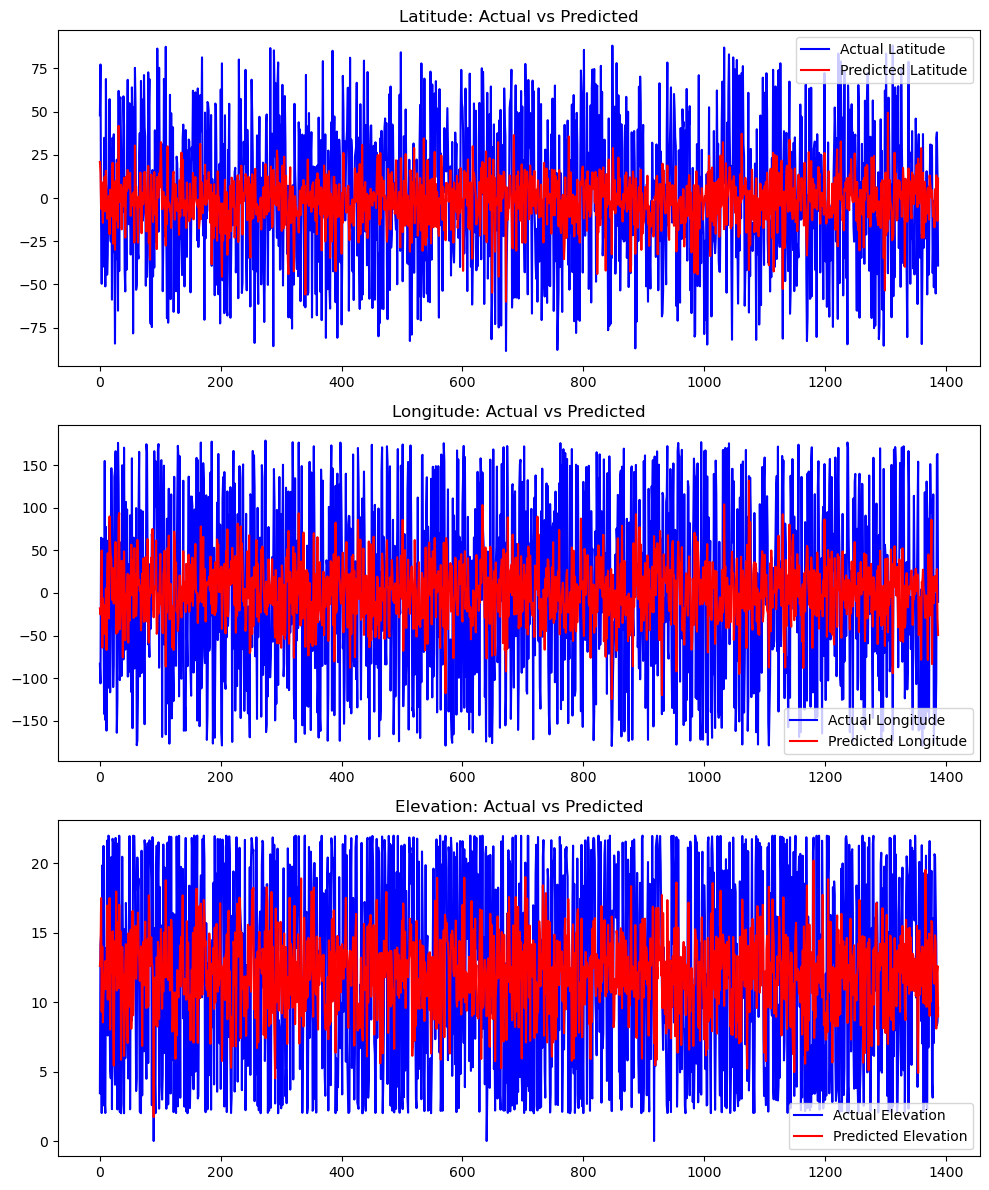

In [62]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.pyplot as plt

class BalloonTrajectoryPredictor:
    def __init__(self, data_file):
        self.data = pd.read_csv(data_file)
        self.scaler_x = StandardScaler()
        self.scaler_y = StandardScaler()

    def preprocess_data(self):
        features = []
        targets = []
        
        valid_rows = 0  
        for _, row in self.data.iterrows():
            balloon_id = row['balloon_id']
            coordinates = []
            for hour in range(8):
                coord = row[f'hour_{hour}']
                if isinstance(coord, str) and coord.startswith('[') and coord.endswith(']'):  
                    try:
                        coord = eval(coord)  
                    except:
                        coord = [np.nan, np.nan, np.nan, np.nan] 
                if isinstance(coord, list) and len(coord) == 4 and not any(np.isnan(c) for c in coord):  
                    coordinates.append(coord)
                else:
                    break  

            if len(coordinates) == 8:
                valid_rows += 1 
                for i in range(1, len(coordinates)):  
                    lat, lon, elevation, pressure = coordinates[i]
                    prev_lat, prev_lon, prev_elevation, prev_pressure = coordinates[i - 1]
                    features.append([lat - prev_lat, lon - prev_lon, elevation - prev_elevation, pressure - prev_pressure])
                    targets.append([lat, lon, elevation]) 

        print(f"Valid rows processed: {valid_rows}")  
        return np.array(features), np.array(targets)

    def train_model(self):
        X, y = self.preprocess_data()

        if X.size == 0 or y.size == 0:
            raise ValueError("The feature matrix X or the target matrix y is empty.")

       
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        
        X_scaled = self.scaler_x.fit_transform(X_train)
        y_scaled = self.scaler_y.fit_transform(y_train)

        
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_scaled, y_scaled)

       
        X_test_scaled = self.scaler_x.transform(X_test)
        y_test_scaled = self.scaler_y.transform(y_test)
        y_pred_scaled = model.predict(X_test_scaled)
        
        
        mse = mean_squared_error(y_test_scaled, y_pred_scaled)
        print(f"Mean Squared Error (MSE) on Test Set: {mse}")

        
        with open('balloon_trajectory_model_rf.pkl', 'wb') as f:
            pickle.dump(model, f)
        with open('scaler_x.pkl', 'wb') as f:
            pickle.dump(self.scaler_x, f)
        with open('scaler_y.pkl', 'wb') as f:
            pickle.dump(self.scaler_y, f)

        return model, X_test, y_test

    def predict_and_plot(self, model, X_test, y_test):
       
        X_scaled = self.scaler_x.transform(X_test)
        y_pred_scaled = model.predict(X_scaled)
        y_pred = self.scaler_y.inverse_transform(y_pred_scaled)

        
        fig, axes = plt.subplots(3, 1, figsize=(10, 12))

        
        axes[0].plot(y_test[:, 0], label="Actual Latitude", color='b')
        axes[0].plot(y_pred[:, 0], label="Predicted Latitude", color='r')
        axes[0].set_title('Latitude: Actual vs Predicted')
        axes[0].legend()

        
        axes[1].plot(y_test[:, 1], label="Actual Longitude", color='b')
        axes[1].plot(y_pred[:, 1], label="Predicted Longitude", color='r')
        axes[1].set_title('Longitude: Actual vs Predicted')
        axes[1].legend()

       
        axes[2].plot(y_test[:, 2], label="Actual Elevation", color='b')
        axes[2].plot(y_pred[:, 2], label="Predicted Elevation", color='r')
        axes[2].set_title('Elevation: Actual vs Predicted')
        axes[2].legend()

       
        plt.tight_layout()
        plt.show()


predictor = BalloonTrajectoryPredictor("combined_balloon_data_with_elevation.csv")
model, X_test, y_test = predictor.train_model()


predictor.predict_and_plot(model, X_test, y_test)


In [4]:
import pandas as pd
import ast
import numpy as np


file_path = "combined_balloon_data_with_import pandas as pd
import ast
import numpy as np


file_path = "combined_balloon_data_elevation.csv" 
df = pd.read_csv(file_path)


hour_columns = [col for col in df.columns if "hour_" in col]


def extract_altitude_ground(value):
    try:
        values = ast.literal_eval(value)  
        if len(values) >= 4:  
            return values[2], values[3]
        else:
            return None, None  
    except (SyntaxError, ValueError, TypeError):
        return None, None  


results = []


for index, row in df.iterrows():
    balloon_id = row["balloon_id"]
    altitudes = []
    ground_elevations = []

    
    for col in hour_columns:
        altitude, ground = extract_altitude_ground(row[col])
        if altitude is not None and ground is not None: 
            altitudes.append(altitude)
            ground_elevations.append(ground)

    if len(altitudes) < 2:
        continue  

    
    ascent_rates = np.diff(altitudes)

    
    max_altitude = max(altitudes) if altitudes else None

    
    agl_values = np.array(altitudes) - np.array(ground_elevations)
    max_agl = max(agl_values) if len(agl_values) > 0 else None

    
    results.append({
        "balloon_id": balloon_id,
        "max_altitude": max_altitude,
        "max_agl": max_agl,
        "avg_ascent_rate": np.mean(ascent_rates) if len(ascent_rates) > 0 else None,
        "max_ascent_rate": max(ascent_rates) if len(ascent_rates) > 0 else None,
        "min_ascent_rate": min(ascent_rates) if len(ascent_rates) > 0 else None,
    })


results_df = pd.DataFrame(results)
results_df.to_csv("balloon_analysis_results.csv", index=False)


print(results_df.describe())
print("Analysis complete! Results saved to 'balloon_analysis_results.csv'.")
elevation.csv"  # Update with your actual file path
df = pd.read_csv(file_path)


hour_columns = [col for col in df.columns if "hour_" in col]


def extract_altitude_ground(value):
    try:
        values = ast.literal_eval(value)  
        if len(values) >= 4:  
            return values[2], values[3]  
        else:
            return None, None  
    except (SyntaxError, ValueError, TypeError):
        return None, None  


results = []


for index, row in df.iterrows():
    balloon_id = row["balloon_id"]
    altitudes = []
    ground_elevations = []

    
    for col in hour_columns:
        altitude, ground = extract_altitude_ground(row[col])
        if altitude is not None and ground is not None:  
            altitudes.append(altitude)
            ground_elevations.append(ground)

    if len(altitudes) < 2:
        continue  

    
    ascent_rates = np.diff(altitudes)

    
    max_altitude = max(altitudes) if altitudes else None

    
    agl_values = np.array(altitudes) - np.array(ground_elevations)
    max_agl = max(agl_values) if len(agl_values) > 0 else None

   
    results.append({
        "balloon_id": balloon_id,
        "max_altitude": max_altitude,
        "max_agl": max_agl,
        "avg_ascent_rate": np.mean(ascent_rates) if len(ascent_rates) > 0 else None,
        "max_ascent_rate": max(ascent_rates) if len(ascent_rates) > 0 else None,
        "min_ascent_rate": min(ascent_rates) if len(ascent_rates) > 0 else None,
    })


results_df = pd.DataFrame(results)
results_df.to_csv("balloon_analysis_results.csv", index=False)


print(results_df.describe())
print("Analysis complete! Results saved to 'balloon_analysis_results.csv'.")


        balloon_id  max_altitude      max_agl  avg_ascent_rate  \
count  1000.000000   1000.000000  1000.000000      1000.000000   
mean    499.500000     20.380263  3646.078157        -0.000130   
std     288.819436      3.555543  2228.814315         0.991505   
min       0.000000      2.684638 -3432.995033        -1.985678   
25%     249.750000     21.062933  2630.937827        -0.724627   
50%     499.500000     21.846729  4528.497794         0.008778   
75%     749.250000     21.978124  5274.588474         0.759165   
max     999.000000     21.999997  6814.536814         1.991863   

       max_ascent_rate  min_ascent_rate  
count      1000.000000      1000.000000  
mean          6.097859        -6.168328  
std           3.974017         3.934452  
min          -0.862615       -21.999405  
25%           2.847659        -8.985936  
50%           6.208597        -6.254017  
75%           8.954196        -2.962090  
max          21.293065         0.779577  
Analysis complete! Results 

In [5]:
import pandas as pd
import numpy as np


file_path = "balloon_analysis_results.csv"
df = pd.read_csv(file_path)


mean_ascent = df["avg_ascent_rate"].mean()
std_ascent = df["avg_ascent_rate"].std()


upper_threshold = mean_ascent + 2 * std_ascent
lower_threshold = mean_ascent - 2 * std_ascent


ascent_anomalies = df[(df["avg_ascent_rate"] > upper_threshold) | (df["avg_ascent_rate"] < lower_threshold)]


significant_falls = df[df["avg_ascent_rate"] < 0] 
significant_falls = significant_falls[significant_falls["min_ascent_rate"] < -5] 


correlation = df[["avg_ascent_rate", "max_altitude", "max_agl", "max_ascent_rate", "min_ascent_rate"]].corr()


ascent_anomalies.to_csv("ascent_anomalies.csv", index=False)
significant_falls.to_csv("significant_falls.csv", index=False)


print("Ascent Anomalies Detected:", len(ascent_anomalies))
print("Significant Falls Detected:", len(significant_falls))
print("\nCorrelation Matrix:\n", correlation)
print("\nAnalysis complete! Anomalies saved to 'ascent_anomalies.csv' and 'significant_falls.csv'.")



Ascent Anomalies Detected: 3
Significant Falls Detected: 350

Correlation Matrix:
                  avg_ascent_rate  max_altitude   max_agl  max_ascent_rate  \
avg_ascent_rate         1.000000     -0.014860 -0.014748         0.294075   
max_altitude           -0.014860      1.000000  0.014646         0.407032   
max_agl                -0.014748      0.014646  1.000000        -0.002123   
max_ascent_rate         0.294075      0.407032 -0.002123         1.000000   
min_ascent_rate         0.236838     -0.413929 -0.034018        -0.690710   

                 min_ascent_rate  
avg_ascent_rate         0.236838  
max_altitude           -0.413929  
max_agl                -0.034018  
max_ascent_rate        -0.690710  
min_ascent_rate         1.000000  

Analysis complete! Anomalies saved to 'ascent_anomalies.csv' and 'significant_falls.csv'.


In [7]:
import pandas as pd


file_path = "balloon_analysis_results.csv"
df = pd.read_csv(file_path)


troposphere_limit = 12000  #(troposphere)
stratosphere_limit = 50000  #(upper limit for most weather balloons)
ground_level_limit = 0  # Should not be negative

df["highest_altitude"] = df["max_altitude"]
df["lowest_altitude"] = df["max_altitude"] + df["min_ascent_rate"]  


df["above_stratosphere"] = df["highest_altitude"] > stratosphere_limit
df["below_ground"] = df["lowest_altitude"] < ground_level_limit


violations = df[(df["above_stratosphere"]) | (df["below_ground"])]


violations.to_csv("altitude_violations.csv", index=False)


print(f"Total Balloons Exceeding Limits: {len(violations)}")
print(violations[["balloon_id", "highest_altitude", "lowest_altitude", "above_stratosphere", "below_ground"]])


Total Balloons Exceeding Limits: 0
Empty DataFrame
Columns: [balloon_id, highest_altitude, lowest_altitude, above_stratosphere, below_ground]
Index: []


In [12]:
import pandas as pd


file_path = "balloon_analysis_results.csv"
df = pd.read_csv(file_path)


df["height_above_surface"] = df["max_altitude"] - df["max_agl"]


df.to_csv("balloon_height_log.csv", index=False)


print(f"Logged heights for {len(df)} balloons.")
print(df[["balloon_id", "max_altitude", "max_agl", "height_above_surface"]].head())

print("\nHeight log saved to 'balloon_height_log.csv'.")




Logged heights for 1000 balloons.
   balloon_id  max_altitude      max_agl  height_above_surface
0           0     11.504971  5357.566649          -5346.061678
1           1     21.751384  3196.358310          -3174.606926
2           2     21.546668  3050.314542          -3028.767875
3           3     12.380648  4466.093325          -4453.712676
4           4     21.911565  2829.889129          -2807.977564

Height log saved to 'balloon_height_log.csv'.


In [ ]:
"""
Had a great time working on this assignment—it was both fun and challenging! I really enjoyed the 
process and would love the chance to chat more about how I can contribute. Looking forward to discussing 
further and sharing more about my approach!
"""
